# BERT base uncased, soma dos score do par.

## HypeNET - Train
- (1,1) é um par onde hipônimo e hiperônimo são de tamanho 1
- O tamanho do par (1,1) será 2, assim como o tamanho do par (2,1) e (1,2) será 3

> Suponha o par (3,2) (abacate, fruta)
> Temos as seguintes sentenças:
- [MASK] ca te é um tipo de fru ta
- aba [MASK] te é um tipo de fru ta
- aba ca [MASK] é um tipo de fru ta
- aba ca te é um tipo de [MASK] ta
- aba ca te é um tipo de fru [MASK]

> Mascarando a palavra e pegando o score dela. O score pra esse par será a soma de todos os valores recuperados.


In [32]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append("/home/gabrielescobar/hyper_bert")
import nb_utils


sns.set(style="whitegrid")
plt.clf()

#server
path_file_bert = "../../en-model/bert-base-uncased_bert_score_2020-11-11_20:24:14_HypeNet_train/HypeNet_train.json"
json_data = json.load(open(path_file_bert))

df_with_oov = nb_utils.create_dataframe(json_data, separator="\t")


pattern_unique = df_with_oov['pattern'].unique().tolist()
len_total_unique = df_with_oov['len_total'].unique().tolist()

print(f"DF all with OOV = {df_with_oov[df_with_oov['pattern'] == pattern_unique[0]].count()['hiponimo']}")

# df com oov
df_with_oov = nb_utils.logsumexp_normalization(df_with_oov, len_list=len_total_unique, pattern_list=pattern_unique)

DF all with OOV = 49475


<Figure size 432x288 with 0 Axes>

In [33]:
# df.update(df.loc[df['len_total'] == 11, 'score_final_log(z)'].apply(lambda x: x * 1.5))
for i in range(6, 19):
    df_with_oov.update(df_with_oov.loc[df_with_oov['len_total'] == i, 'score_final_log(z)'].apply(lambda x: x * 3.5))

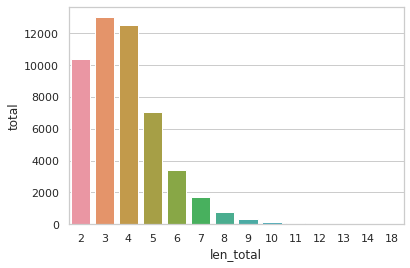

In [34]:
# Balanceamento df_with_oov
df_with_oov_ratio = nb_utils.balanceamento(df_with_oov, patterns=pattern_unique,len_size=len_total_unique)
df_with_oov_ratio['total'] = df_with_oov_ratio['true'] + df_with_oov_ratio['false']
ax = sns.barplot(x="len_total", y="total", data=df_with_oov_ratio)

## Balanceamento do Dataset e AP por padrão (usando log(z))
#### Todo dataset
 - N = 49475 pares

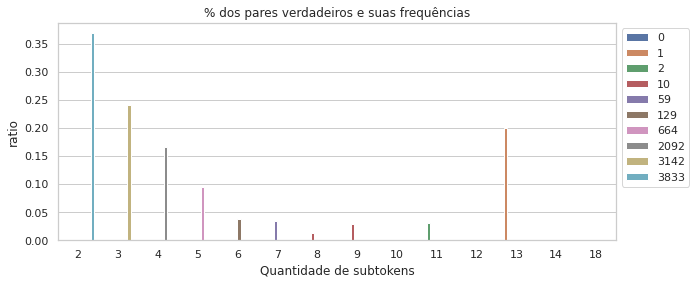

In [35]:
# Balanceamento df_with_oov
df_with_oov_ratio = nb_utils.balanceamento(df_with_oov, patterns=pattern_unique,len_size=len_total_unique)

plt.figure(figsize=(10, 4))
ax = sns.barplot(x="len_total", y="ratio", hue="true", data=df_with_oov_ratio)
ax.set(xlabel="Quantidade de subtokens")
ax.set_title(f"% dos pares verdadeiros e suas frequências")
ax.legend(bbox_to_anchor=(1, 1))

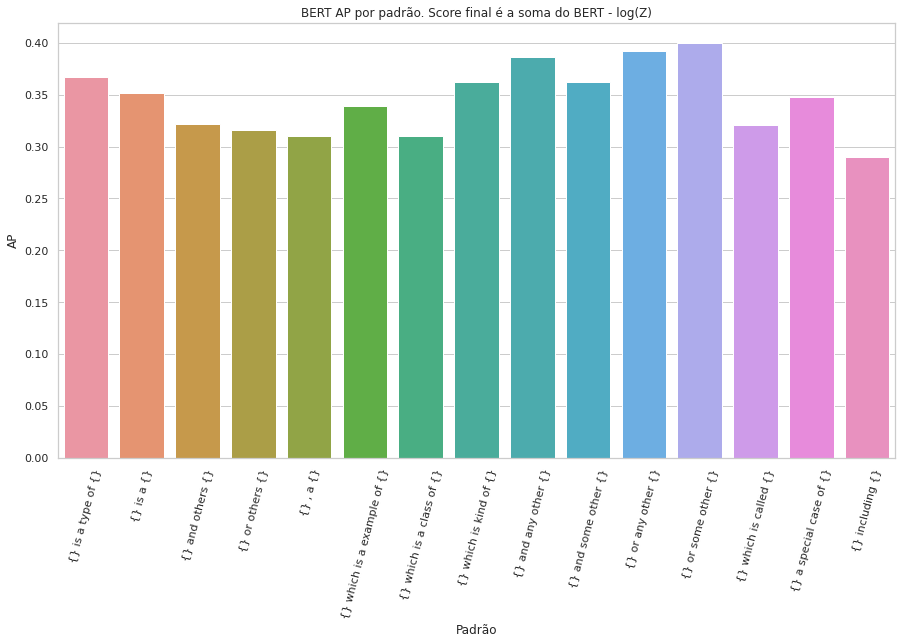

Melhores padrões usando score_final_log(Z)
['{} or some other {}', '{} or any other {}', '{} and any other {}', '{} is a type of {}', '{} which is kind of {}', '{} and some other {}', '{} is a {}', '{} a special case of {}', '{} which is a example of {}', '{} and others {}', '{} which is called {}', '{} or others {}', '{} which is a class of {}', '{} , a {}', '{} including {}']


In [36]:
# AP por padrão
df_plot = nb_utils.compute_dataframe_AP_by_pattern(df_with_oov, key_sort="score_final_log(z)", pattern_list=pattern_unique)
plt.figure(figsize=(15, 8))
ax = sns.barplot(data=df_plot, x='padrao', y='AP')
ax.set(xlabel="Padrão")
ax.set_title(f"BERT AP por padrão. Score final é a soma do BERT - log(Z)")
plt.xticks(rotation=75)
plt.show()

print(f"Melhores padrões usando score_final_log(Z)")
best_pattern_logz = df_plot.sort_values(by='AP', ascending=False)['padrao'].tolist()
print(best_pattern_logz)

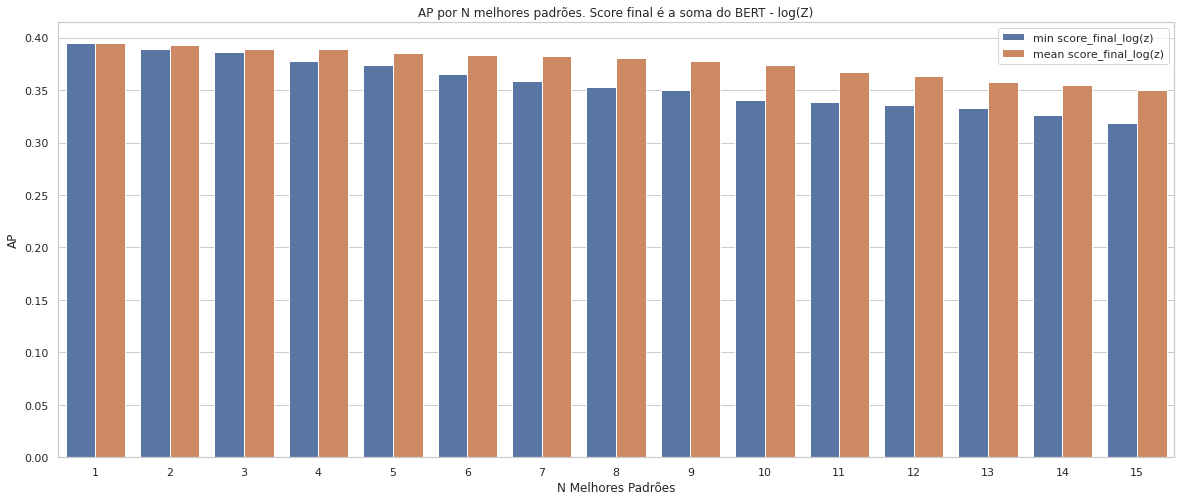

In [37]:
# AP por n-rank
df_plot = nb_utils.compute_AP_n_best_pattern(df_with_oov, key_sort="score_final_log(z)", n_best_pattern=best_pattern_logz)
plt.figure(figsize=(20, 8))
ax = sns.barplot(data=df_plot, x='n_best_pattern', y='AP', hue='method')
ax.set(xlabel="N Melhores Padrões")
ax.set_title(f"AP por N melhores padrões. Score final é a soma do BERT - log(Z)")
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

In [38]:
df_mean = df_plot[df_plot['method'] == 'mean score_final_log(z)']
df_mean = df_mean.sort_values(by='AP', ascending=False)
print(f"Melhor combinação de Melhores Padrões usando Média dos ranks entre eles")
print(df_mean.iloc[:4])

print(f"Melhor combinação de Melhores Padrões usando Minimo dos ranks entre eles")
df_min = df_plot[df_plot['method'] == 'min score_final_log(z)']
df_min = df_min.sort_values(by='AP', ascending=False)
print(df_min.iloc[:4])

Melhor combinação de Melhores Padrões usando Média dos ranks entre eles
   n_best_pattern                   method        AP
1               1  mean score_final_log(z)  0.394768
3               2  mean score_final_log(z)  0.392690
7               4  mean score_final_log(z)  0.389328
5               3  mean score_final_log(z)  0.389283
Melhor combinação de Melhores Padrões usando Minimo dos ranks entre eles
   n_best_pattern                  method        AP
0               1  min score_final_log(z)  0.394768
2               2  min score_final_log(z)  0.388753
4               3  min score_final_log(z)  0.386394
6               4  min score_final_log(z)  0.377361


In [39]:
# balanceamento do dataset inteiro
df_size = nb_utils.balanceamento_all(df_with_oov, patterns=pattern_unique)
df_size

,true,false,total
0,9942.00000,39533.00000,49475
1,0.20095,0.79905,1


## Balanceamento do Dataset e AP por padrão (usando bert_soma_total)
#### Todo dataset
 - N = 49475 pares

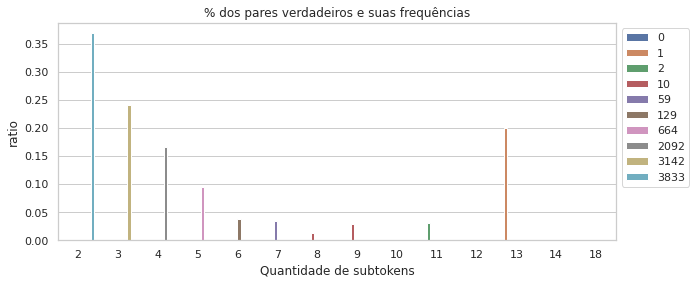

In [40]:
# Balanceamento df_with_oov
df_with_oov_ratio = nb_utils.balanceamento(df_with_oov, patterns=pattern_unique,len_size=len_total_unique)

plt.figure(figsize=(10, 4))
ax = sns.barplot(x="len_total", y="ratio", hue="true", data=df_with_oov_ratio)
ax.set(xlabel="Quantidade de subtokens")
ax.set_title(f"% dos pares verdadeiros e suas frequências")
ax.legend(bbox_to_anchor=(1, 1))

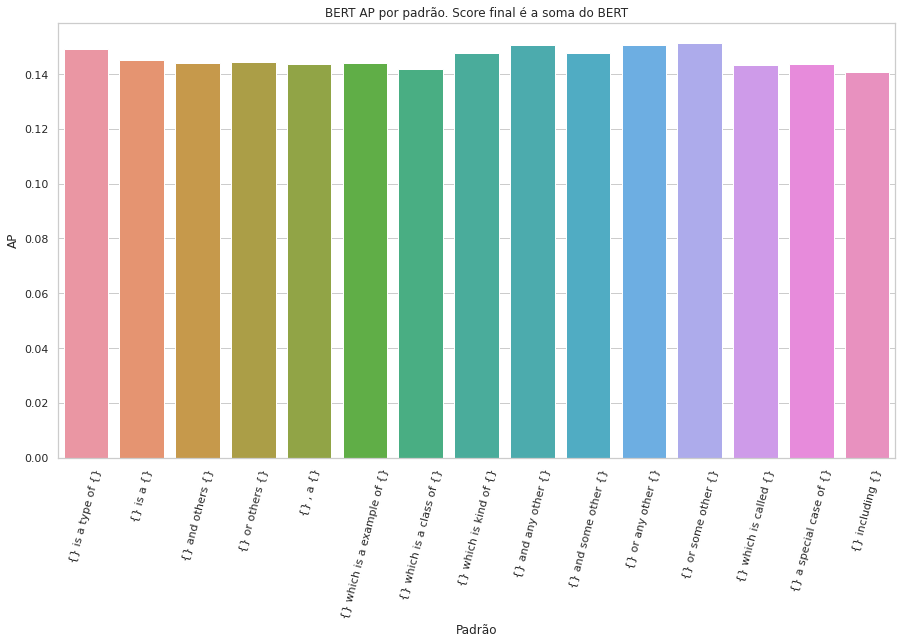

Melhores padrões usando bert_soma_total
['{} or some other {}', '{} and any other {}', '{} or any other {}', '{} is a type of {}', '{} and some other {}', '{} which is kind of {}', '{} is a {}', '{} or others {}', '{} and others {}', '{} which is a example of {}', '{} a special case of {}', '{} , a {}', '{} which is called {}', '{} which is a class of {}', '{} including {}']


In [41]:
# AP por padrão
df_plot = nb_utils.compute_dataframe_AP_by_pattern(df_with_oov, key_sort="bert_soma_total", pattern_list=pattern_unique)
plt.figure(figsize=(15, 8))
ax = sns.barplot(data=df_plot, x='padrao', y='AP')
ax.set(xlabel="Padrão")
ax.set_title(f"BERT AP por padrão. Score final é a soma do BERT")
plt.xticks(rotation=75)
plt.show()

print(f"Melhores padrões usando bert_soma_total")
best_pattern_bert_soma_total = df_plot.sort_values(by='AP', ascending=False)['padrao'].tolist()
print(best_pattern_bert_soma_total)

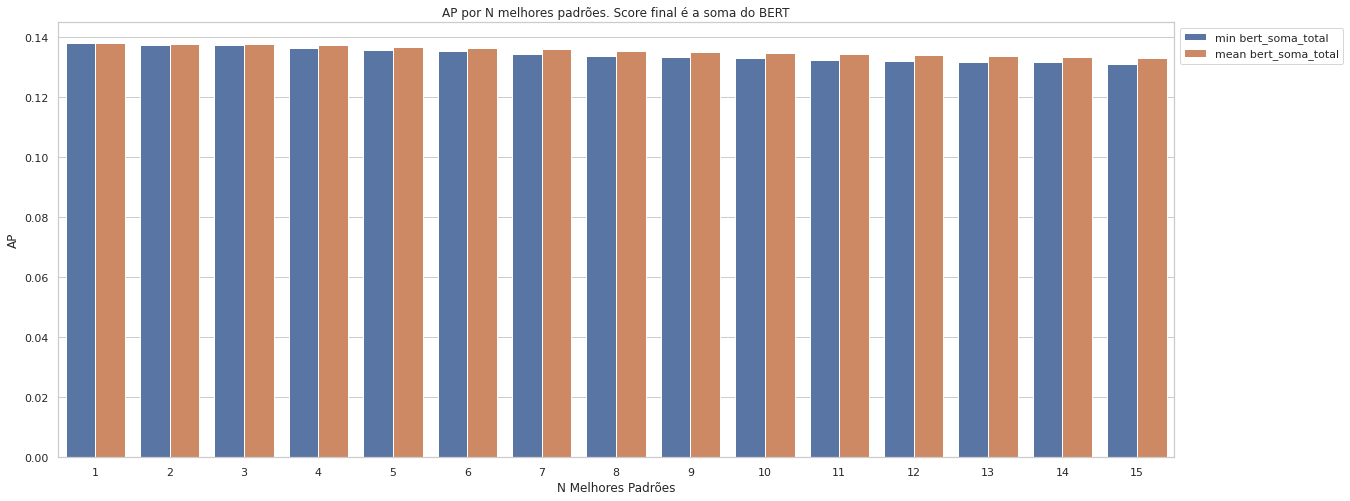

In [42]:
# AP por n-rank
df_plot = nb_utils.compute_AP_n_best_pattern(df_with_oov, key_sort="bert_soma_total", n_best_pattern=best_pattern_bert_soma_total)
plt.figure(figsize=(20, 8))
ax = sns.barplot(data=df_plot, x='n_best_pattern', y='AP', hue='method')
ax.set(xlabel="N Melhores Padrões")
ax.set_title(f"AP por N melhores padrões. Score final é a soma do BERT")
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

In [43]:
df_mean = df_plot[df_plot['method'] == 'mean bert_soma_total']
df_mean = df_mean.sort_values(by='AP', ascending=False)
print(f"Melhor combinação de Melhores Padrões usando Média dos ranks entre eles")
print(df_mean.iloc[:4])

print(f"Melhor combinação de Melhores Padrões usando Minimo dos ranks entre eles")
df_min = df_plot[df_plot['method'] == 'min bert_soma_total']
df_min = df_min.sort_values(by='AP', ascending=False)
print(df_min.iloc[:4])

Melhor combinação de Melhores Padrões usando Média dos ranks entre eles
   n_best_pattern                method        AP
1               1  mean bert_soma_total  0.138053
3               2  mean bert_soma_total  0.137715
5               3  mean bert_soma_total  0.137635
7               4  mean bert_soma_total  0.137393
Melhor combinação de Melhores Padrões usando Minimo dos ranks entre eles
   n_best_pattern               method        AP
0               1  min bert_soma_total  0.138053
2               2  min bert_soma_total  0.137568
4               3  min bert_soma_total  0.137456
6               4  min bert_soma_total  0.136278


In [44]:
# balanceamento do dataset inteiro
df_size = nb_utils.balanceamento_all(df_with_oov, patterns=pattern_unique)
df_size

,true,false,total
0,9942.00000,39533.00000,49475
1,0.20095,0.79905,1
